<a href="https://colab.research.google.com/github/cenzwong/MSBD5012/blob/main/MSBD5012_River.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# River Implementation

In [1]:
!pip install git+https://github.com/online-ml/river --upgrade
!pip install -U numpy

  Cloning https://github.com/online-ml/river to /tmp/pip-req-build-g5330mlb
  Running command git clone -q https://github.com/online-ml/river /tmp/pip-req-build-g5330mlb
  Created wheel for river: filename=river-0.8.0-cp37-cp37m-linux_x86_64.whl size=2143852 sha256=68fc9fbbf6a57340f5bef0690ac566e26727defc876c42fa9e00427b41db8165
  Stored in directory: /tmp/pip-ephem-wheel-cache-vcwdx64q/wheels/a1/81/b6/35dc3f68cb6c44cc3967a6a2f40410150d6ed5df2ff2b83f41
Successfully built river
     |████████████████████████████████| 15.7 MB 8.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires foliu

In [2]:
# !gdown https://drive.google.com/uc?id=1LHDaW3vqUBcA7yPUh3CiV5muJn7d0EFD
!wget https://raw.githubusercontent.com/cenzwong/MSBD5012/main/data/train.csv.zip -O train.csv.zip
!unzip train.csv.zip

--2021-11-26 13:15:28--  https://raw.githubusercontent.com/cenzwong/MSBD5012/main/data/train.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23570978 (22M) [application/zip]
Saving to: ‘train.csv.zip’

train.csv.zip       100%[===================>]  22.48M   136MB/s    in 0.2s    

2021-11-26 13:15:29 (136 MB/s) - ‘train.csv.zip’ saved [23570978/23570978]

Archive:  train.csv.zip
  inflating: train.csv               


In [3]:
import numpy as np
import pandas as pd

df_csv = pd.read_csv('./train.csv', usecols=['id', 'date', 'family', 'sales'], header=0)

data = df_csv.copy()
data['date'] = pd.to_datetime(data['date'], format = "%Y-%m-%d")
df_train_mag_sales = data.loc[(data['family'] == 'MAGAZINES') & ((data['date'] >= '2014-01-01') & (data['date'] <= '2017-06-30'))].groupby(['date']).sum().copy()
df_train_mag_sales = df_train_mag_sales.loc[:, 'sales':'sales']

data = df_csv.copy()
data['date'] = pd.to_datetime(data['date'], format = "%Y-%m-%d")
df_test_mag_sales = data.loc[(data['family'] == 'MAGAZINES') & ((data['date'] >= '2017-07-1') & (data['date'] <= '2017-08-15'))].groupby(['date']).sum().copy()
df_test_mag_sales = df_test_mag_sales.loc[:, 'sales':'sales']


In [4]:
# from river import stream

# rv_train = stream.iter_csv(
#     '/content/train.csv',
#     converters={
#         'sales':float
#     },
#     drop = ['id', 'family', 'onpromotion', 'store_nbr'],
#     parse_dates={'date': '%Y-%m-%d'},
#     target='sales'
# )

# for x, y in rv_train:
#     print(x, y)
#     break

In [20]:
df_train_mag_sales.head(2)
df_train_mag_sales.to_csv('train_clean.csv', index=True)

In [21]:
params = {
  'converters': {'sales': float},
  'parse_dates': {'date': '%Y-%m-%d'} 
  }
next(stream.iter_csv('train_clean.csv', target='sales', **params))

({'date': datetime.datetime(2014, 1, 1, 0, 0)}, 1.0)

In [22]:
from river import compose
from river import linear_model
from river import preprocessing


def get_ordinal_date(x):
    return {'ordinal_date': x['date'].toordinal()}


model = compose.Pipeline(
    ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
)

In [23]:
from river import metrics
import matplotlib.pyplot as plt


def evaluate_model(model): 

    metric = metrics.Rolling(metrics.MAE(), 12)

    dates = []
    y_trues = []
    y_preds = []

    params = {
     'converters': {'sales': float},
     'parse_dates': {'date': '%Y-%m-%d'} 
     }
    for x, y in stream.iter_csv('train_clean.csv', target='sales', **params):

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)

        # Update the error metric
        metric.update(y, y_pred)

        # Store the true value and the prediction
        dates.append(x['date'])
        y_trues.append(y)
        y_preds.append(y_pred)

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax.legend()
    ax.set_title(metric)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


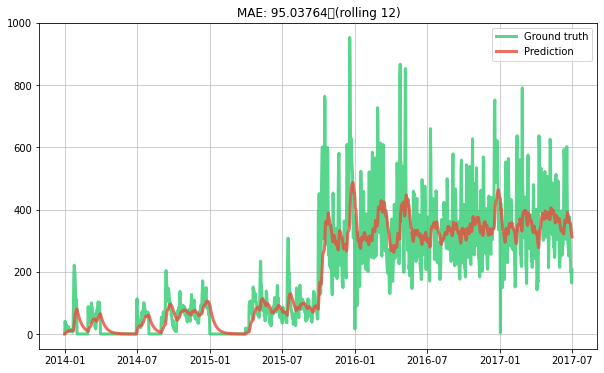

In [24]:
evaluate_model(model)


In [ ]:
from river import datasets

for x, y in datasets.AirlinePassengers():
    print(x, y)
    print(x['month'].toordinal())
    break

In [ ]:
from river import compose
from river import linear_model
from river import preprocessing


def get_ordinal_date(x):
    return {'ordinal_date': x['month'].toordinal()}


model = compose.Pipeline(
    ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
)

In [ ]:
from river import metrics
import matplotlib.pyplot as plt


def evaluate_model(model): 

    metric = metrics.Rolling(metrics.MAE(), 12)

    dates = []
    y_trues = []
    y_preds = []

    for x, y in datasets.AirlinePassengers():

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)

        # Update the error metric
        metric.update(y, y_pred)

        # Store the true value and the prediction
        dates.append(x['month'])
        y_trues.append(y)
        y_preds.append(y_pred)

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax.legend()
    ax.set_title(metric)

In [ ]:
evaluate_model(model)